<a href="https://colab.research.google.com/github/LucyMariel/Lucy/blob/master/DIVICDecisionTreeScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are many ways to learn a decision tree, but we'll scratch one of them.

The decision tree created depends on the learning method, hyperparameters, and training data.

In [1]:
import numpy as np

# Data
X = np.array([80, 120, 100, 50, 30, 20, 20, 50, 120, 60]).reshape(-1, 1)
y = np.array(['No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes'])

class DecisionTreeClassifier:
    def __init__(self, min_samples_split=2, max_depth=2):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree = None

    def _gini_index(self, groups, classes):
        # Count all samples at split point
        n_instances = float(sum([len(group) for group in groups]))

        # Sum weighted Gini index for each group
        gini = 0.0
        for group in groups:
            size = float(len(group))
            if size == 0:
                continue
            score = 0.0
            for class_val in classes:
                p = (group[:, -1] == class_val).sum() / size
                score += p * p
            gini += (1.0 - score) * (size / n_instances)
        return gini

    def _test_split(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return np.array(left), np.array(right)

    def _get_split(self, dataset):
        class_values = np.unique(dataset[:, -1])
        b_index, b_value, b_score, b_groups = 999, 999, 999, None
        for index in range(dataset.shape[1] - 1):
            for row in dataset:
                groups = self._test_split(index, row[index], dataset)
                gini = self._gini_index(groups, class_values)
                if gini < b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], gini, groups
        return {'index': b_index, 'value': b_value, 'groups': b_groups}

    def _to_terminal(self, group):
        outcomes = group[:, -1]
        return np.bincount(outcomes).argmax()

    def _split(self, node, depth):
        left, right = node['groups']
        del(node['groups'])

        if not left.tolist() or not right.tolist():
            node['left'] = node['right'] = self._to_terminal(np.vstack((left, right)))
            return

        if depth >= self.max_depth:
            node['left'], node['right'] = self._to_terminal(left), self._to_terminal(right)
            return

        if len(left) <= self.min_samples_split:
            node['left'] = self._to_terminal(left)
        else:
            node['left'] = self._get_split(left)
            self._split(node['left'], depth + 1)

        if len(right) <= self.min_samples_split:
            node['right'] = self._to_terminal(right)
        else:
            node['right'] = self._get_split(right)
            self._split(node['right'], depth + 1)

    def fit(self, X, y):
        dataset = np.column_stack((X, y))
        self.tree = self._get_split(dataset)
        self._split(self.tree, 1)

    def _predict(self, node, row):
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self._predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self._predict(node['right'], row)
            else:
                return node['right']

    def predict(self, X):
        predictions = [self._predict(self.tree, row) for row in X]
        return np.array(predictions)

# Encode labels as integers
y_encoded = np.where(y == 'Yes', 1, 0)

# Create and train the decision tree classifier
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X, y_encoded)

# Predict
predictions = dt.predict(X)
predictions = np.where(predictions == 1, 'Yes', 'No')

print(f"Predictions: {predictions}")



Predictions: ['No' 'Yes' 'Yes' 'No' 'No' 'No' 'No' 'No' 'Yes' 'Yes']


PROCESSES

Calculate Gini Index: Measure the impurity of a dataset.
Split the Dataset: Split the dataset based on the attribute and threshold.
Calculate the Best Split: Iterate through all possible splits to find the one with the lowest Gini index.
Build the Tree: Recursively split the dataset to build the tree until a stopping criterion is met.
Make Predictions: Use the trained tree to make predictions on new data.

Adding the function to calculate the Information Gain (IG) for splitting nodes involves calculating the entropy of the parent node and the weighted average entropy of the child nodes. Information Gain is the difference between these two entropies

In [4]:
import numpy as np

# Data
X = np.array([80, 120, 100, 50, 30, 20, 20, 50, 120, 60]).reshape(-1, 1)
y = np.array(['No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes'])

class DecisionTreeClassifier:
    def __init__(self, min_samples_split=2, max_depth=2):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree = None

    def _gini_index(self, groups, classes):
        # Count all samples at split point
        n_instances = float(sum([len(group) for group in groups]))

        # Sum weighted Gini index for each group
        gini = 0.0
        for group in groups:
            size = float(len(group))
            if size == 0:
                continue
            score = 0.0
            for class_val in classes:
                p = (group[:, -1] == class_val).sum() / size
                score += p * p
            gini += (1.0 - score) * (size / n_instances)
        return gini

    def _entropy(self, group):
        if len(group) == 0:
            return 0
        outcomes = group[:, -1]
        class_values, class_counts = np.unique(outcomes, return_counts=True)
        entropy = 0.0
        for count in class_counts:
            p = count / len(outcomes)
            entropy -= p * np.log2(p)
        return entropy

    def _information_gain(self, parent, groups):
        parent_entropy = self._entropy(parent)
        n_instances = float(sum([len(group) for group in groups]))
        weighted_child_entropy = sum([(len(group) / n_instances) * self._entropy(group) for group in groups])
        info_gain = parent_entropy - weighted_child_entropy
        return info_gain

    def _test_split(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return np.array(left), np.array(right)

    def _get_split(self, dataset):
        class_values = np.unique(dataset[:, -1])
        b_index, b_value, b_score, b_groups = 999, 999, -999, None
        for index in range(dataset.shape[1] - 1):
            for row in dataset:
                groups = self._test_split(index, row[index], dataset)
                info_gain = self._information_gain(dataset, groups)
                if info_gain > b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], info_gain, groups
        return {'index': b_index, 'value': b_value, 'groups': b_groups}

    def _to_terminal(self, group):
        outcomes = group[:, -1]
        return np.bincount(outcomes).argmax()

    def _split(self, node, depth):
        left, right = node['groups']
        del(node['groups'])

        if len(left) == 0 or len(right) == 0:
            combined = np.vstack((left, right))
            node['left'] = node['right'] = self._to_terminal(combined)
            return

        if depth >= self.max_depth:
            node['left'], node['right'] = self._to_terminal(left), self._to_terminal(right)
            return

        if len(left) <= self.min_samples_split:
            node['left'] = self._to_terminal(left)
        else:
            node['left'] = self._get_split(left)
            self._split(node['left'], depth + 1)

        if len(right) <= self.min_samples_split:
            node['right'] = self._to_terminal(right)
        else:
            node['right'] = self._get_split(right)
            self._split(node['right'], depth + 1)

    def fit(self, X, y):
        dataset = np.column_stack((X, y))
        self.tree = self._get_split(dataset)
        self._split(self.tree, 1)

    def _predict(self, node, row):
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self._predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self._predict(node['right'], row)
            else:
                return node['right']

    def predict(self, X):
        predictions = [self._predict(self.tree, row) for row in X]
        return np.array(predictions)

# Encode labels as integers
y_encoded = np.where(y == 'Yes', 1, 0)

# Create and train the decision tree classifier
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X, y_encoded)

# Predict
predictions = dt.predict(X)
predictions = np.where(predictions == 1, 'Yes', 'No')

print(f"Predictions: {predictions}")


Predictions: ['No' 'Yes' 'Yes' 'No' 'No' 'No' 'No' 'No' 'Yes' 'Yes']


Visualize de Decision Area

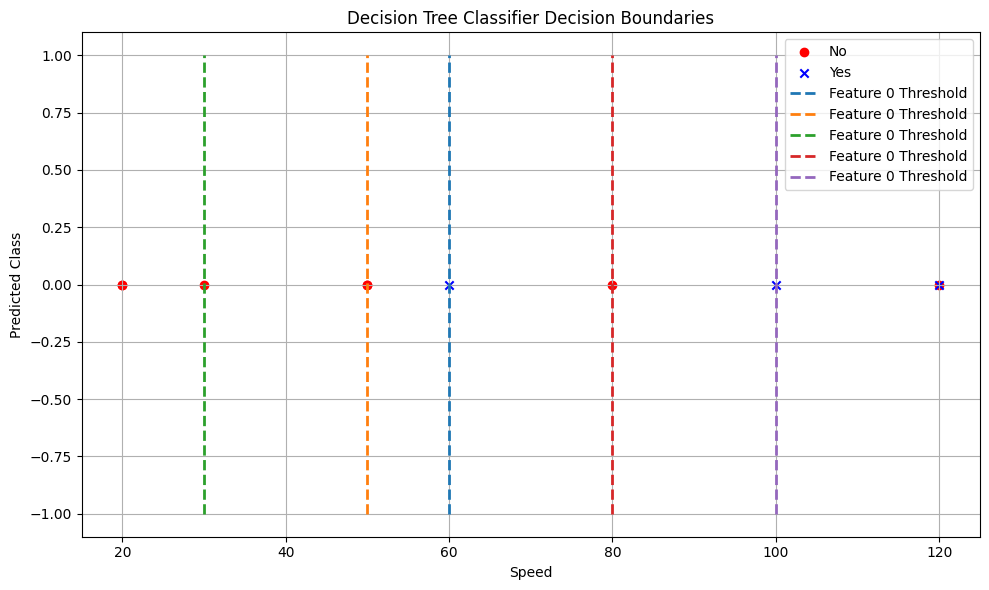

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Data
X = np.array([80, 120, 100, 50, 30, 20, 20, 50, 120, 60]).reshape(-1, 1)
y = np.array(['No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes'])

# Encode labels as integers
y_encoded = np.where(y == 'Yes', 1, 0)

class DecisionTreeClassifier:
    def __init__(self, min_samples_split=2, max_depth=2):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree = None

    def _gini_index(self, groups, classes):
        # Count all samples at split point
        n_instances = float(sum([len(group) for group in groups]))

        # Sum weighted Gini index for each group
        gini = 0.0
        for group in groups:
            size = float(len(group))
            if size == 0:
                continue
            score = 0.0
            for class_val in classes:
                p = (group[:, -1] == class_val).sum() / size
                score += p * p
            gini += (1.0 - score) * (size / n_instances)
        return gini

    def _entropy(self, group):
        if len(group) == 0:
            return 0
        outcomes = group[:, -1]
        class_values, class_counts = np.unique(outcomes, return_counts=True)
        entropy = 0.0
        for count in class_counts:
            p = count / len(outcomes)
            entropy -= p * np.log2(p)
        return entropy

    def _information_gain(self, parent, groups):
        parent_entropy = self._entropy(parent)
        n_instances = float(sum([len(group) for group in groups]))
        weighted_child_entropy = sum([(len(group) / n_instances) * self._entropy(group) for group in groups])
        info_gain = parent_entropy - weighted_child_entropy
        return info_gain

    def _test_split(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return np.array(left), np.array(right)

    def _get_split(self, dataset):
        class_values = np.unique(dataset[:, -1])
        b_index, b_value, b_score, b_groups = 999, 999, -999, None
        for index in range(dataset.shape[1] - 1):
            for row in dataset:
                groups = self._test_split(index, row[index], dataset)
                info_gain = self._information_gain(dataset, groups)
                if info_gain > b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], info_gain, groups
        return {'index': b_index, 'value': b_value, 'groups': b_groups}

    def _to_terminal(self, group):
        outcomes = group[:, -1]
        return np.bincount(outcomes).argmax()

    def _split(self, node, depth):
        left, right = node['groups']
        del(node['groups'])

        if len(left) == 0 or len(right) == 0:
            combined = np.vstack((left, right))
            node['left'] = node['right'] = self._to_terminal(combined)
            return

        if depth >= self.max_depth:
            node['left'], node['right'] = self._to_terminal(left), self._to_terminal(right)
            return

        if len(left) <= self.min_samples_split:
            node['left'] = self._to_terminal(left)
        else:
            node['left'] = self._get_split(left)
            self._split(node['left'], depth + 1)

        if len(right) <= self.min_samples_split:
            node['right'] = self._to_terminal(right)
        else:
            node['right'] = self._get_split(right)
            self._split(node['right'], depth + 1)

    def fit(self, X, y):
        dataset = np.column_stack((X, y))
        self.tree = self._get_split(dataset)
        self._split(self.tree, 1)

    def _predict(self, node, row):
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self._predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self._predict(node['right'], row)
            else:
                return node['right']

    def predict(self, X):
        predictions = [self._predict(self.tree, row) for row in X]
        return np.array(predictions)

# Create and train the decision tree classifier
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X, y_encoded)

# Plot the decision tree predictions
plt.figure(figsize=(10, 6))
plt.scatter(X[y_encoded == 0], np.zeros_like(X[y_encoded == 0]), color='red', marker='o', label='No')
plt.scatter(X[y_encoded == 1], np.zeros_like(X[y_encoded == 1]), color='blue', marker='x', label='Yes')

# Plot decision boundaries based on the splits
def plot_tree_decision_boundary(node, depth=0):
    if isinstance(node, dict):
        feature_index = node['index']
        threshold = node['value']
        plt.plot([threshold, threshold], [-1, 1], '--', linewidth=2, label=f'Feature {feature_index} Threshold')

        plot_tree_decision_boundary(node['left'], depth + 1)
        plot_tree_decision_boundary(node['right'], depth + 1)

plot_tree_decision_boundary(dt.tree)

plt.xlabel('Speed')
plt.ylabel('Predicted Class')
plt.title('Decision Tree Classifier Decision Boundaries')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
